# Neural Networks (RNN, LSTM)

In this notebook, we build neural Networks models to predict values in our timeserie. The algorithms used in this case are **Recurrent Neural Networks (RNN)** and **Long Short-Term Memory (LSTM)**.

----------

### Table of Contents:

[**Read Files**](#Read-Files)\
[**Prepare Data**](#Prepare-Data)\
[**Simple RNN**](#Simple-RNN)\
[**LSTM**](#LSTM)\
[**LSTM (More Neurons)**](#LSTM-(More-Neurons))\
[**LSTM (2 Layers)**](#LSTM-(2-Layers))

----------

# Read Files

In [2]:
# if running in google colab
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [3]:
# if running in google colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# if running in google colab
import os
os.chdir('drive/My Drive/final_version/')

In [1]:
# analysis related libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from time import time
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [3]:
comparison= pd.read_pickle(os.path.join('comparison','comparison.pkl'))

In [4]:
# build df path
df_path= os.path.join('datasets_transformed','data_resampled_noisy_outliers.csv')
# read csv file into a df
df= pd.read_csv(df_path, parse_dates=True, index_col=0)
# check df
df.head()

,metric
2019-12-07 00:00:00,52.500469
2019-12-07 00:01:00,56.685361
2019-12-07 00:02:00,58.306072
2019-12-07 00:03:00,54.528461
2019-12-07 00:04:00,56.962642


# Prepare Data

#### Split Train and Test

In [5]:
# train dataset (7 days)
train_df= df.iloc[:7*int(len(df)/8)]
# test dataset (1 day)
test_df= df.iloc[7*int(len(df)/8):]

In [6]:
train= train_df.values
test= test_df.values

In [7]:
# Test Dataset Share
round(len(test)/len(df),2)

0.13

#### Scale Data

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler= MinMaxScaler(feature_range=(0,1))

In [10]:
# scale only on train set because we don't have info on test set
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [11]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

#### TimeseriesGenerator

In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
# define generator
timesteps = 120 # Length of the sequences # (2 hours)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=timesteps, batch_size=batch_size)

In [14]:
len(scaled_train)

10080

In [15]:
# len(generator)= len(scaled_train)-timesteps
len(generator)

9960

In [16]:
sample_x, sample_y = generator[0]
print('sample input shape:  ',sample_x.shape)
print('sample target shape: ',sample_y.shape)

sample input shape:   (1, 120, 1)
sample target shape:  (1, 1)


In [17]:
val_generator = TimeseriesGenerator(scaled_test,scaled_test,length=timesteps,batch_size=1)

In [18]:
# len(generator)= len(scaled_test)-timesteps
len(val_generator)

1321

In [19]:
### to evaluate test set we need to build a generator for test set
# values to pass into the generator (len(test)+timesteps)
test_gen_vals = np.append(scaled_train[-timesteps:,:], scaled_test).reshape(-1,1)
# build the generator
test_generator = TimeseriesGenerator(test_gen_vals,test_gen_vals,length=timesteps,batch_size=1)

# Simple RNN

#### Model

In [20]:
# define model
model_rnn = Sequential()

n_features=1
# Simple RNN layer
model_rnn.add(SimpleRNN(50,input_shape=(timesteps, n_features)))

# Final Prediction
model_rnn.add(Dense(1))

model_rnn.compile(optimizer='adam', loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [21]:
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [22]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [23]:
start = time()
model_rnn.fit(generator,epochs=10,validation_data=val_generator,callbacks=[early_stop])
time_rnn = time()-start

Epoch 1/10
9960/9960 [==============================] - 319s 32ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 2/10
9960/9960 [==============================] - 302s 30ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 3/10
9960/9960 [==============================] - 300s 30ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 4/10
9960/9960 [==============================] - 289s 29ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/10
9960/9960 [==============================] - 290s 29ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 6/10
9960/9960 [==============================] - 292s 29ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/10
9960/9960 [==============================] - 295s 30ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/10
9960/9960 [==============================] - 300s 30ms/step - loss: 0.0026 - val_loss: 0.0028


In [24]:
model_rnn.save(os.path.join('comparison','model_rnn.h5'))

#### Evaluate

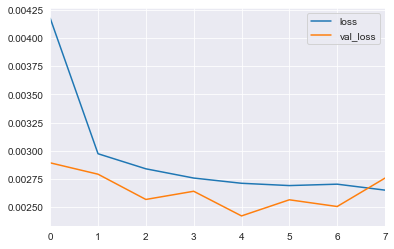

In [25]:
# losses
losses_rnn = pd.DataFrame(model_rnn.history.history)
losses_rnn.to_pickle(os.path.join('comparison','losses_rnn.pkl'))
losses_rnn[['loss','val_loss']].plot()

Evaluate Model Predictions:

In [26]:
# predict values in test set
preds= model_rnn.predict(test_generator)
# inverse scale
true_preds = scaler.inverse_transform(preds)
# save
pd.DataFrame(data={'rnn_preds':true_preds.flatten()},
             index=test_df.index).to_pickle(os.path.join('comparison','rnn_preds.pkl'))

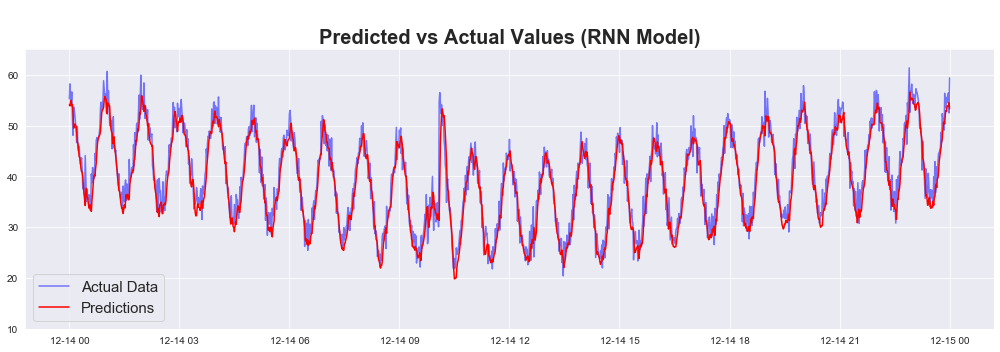

In [27]:
# plot predictions
plt.figure(figsize=(14,5))
plt.title('\nPredicted vs Actual Values (RNN Model)',fontsize=20, fontweight='bold')
plt.plot(test_df, 'b', label = 'Actual Data', alpha=0.5)
plt.plot(test_df.index, true_preds.flatten(), 'r', label = 'Predictions')
plt.legend(prop={'size': 15})
plt.ylim(10,65)
plt.tight_layout()

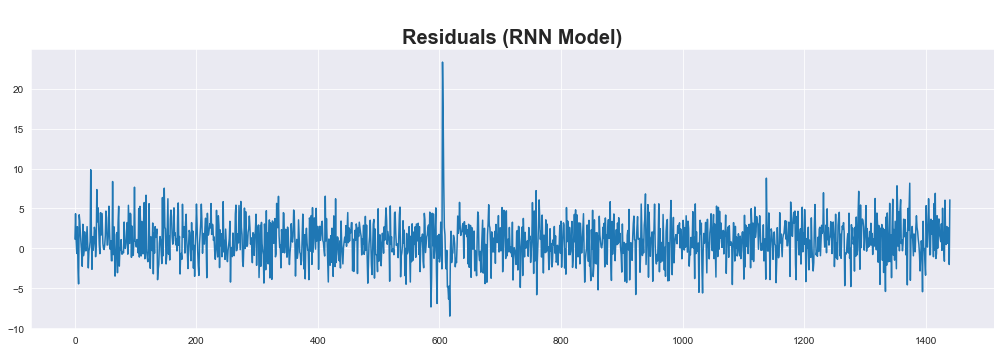

In [28]:
# plot residuals
plt.figure(figsize=(14,5))
plt.title('\nResiduals (RNN Model)',fontsize=20, fontweight='bold')
plt.plot(test_df.values.flatten()-true_preds.flatten())
plt.tight_layout()

In [29]:
## RMSE
RMSE_RNN= np.sqrt(mean_squared_error(test_df.values, true_preds.flatten()))
print('RMSE RNN: ' ,round(RMSE_RNN,4))

RMSE RNN:  2.7802


In [40]:
# save rmse and run time
comparison= pd.concat([comparison,pd.DataFrame({'model':['RNN'],
                                                'time':[time_rnn],
                                                'rmse':[RMSE_RNN]})])

In [41]:
comparison

,model,time,rmse
0,Fourier Transform,0.034534,2.621366
1,SARIMA,149.854580,7.869614
2,TBATS,2420.605045,4.043840
0,RNN,2388.185251,2.780198


# LSTM

#### Model

In [24]:
# define model
model_lstm_less = Sequential()

# LSTM layer
model_lstm_less.add(LSTM(50,input_shape=(timesteps, 1), stateful=False))

# Final Prediction
model_lstm_less.add(Dense(1))

model_lstm_less.compile(optimizer='adam', loss='mse')

In [25]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)
start = time()
model_lstm_less.fit(generator,epochs=15,validation_data=val_generator,callbacks=[early_stop])
time_lstm = time()-start

Train for 9960 steps, validate for 1321 steps
Epoch 1/15
9960/9960 [==============================] - 166s 17ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 2/15
9960/9960 [==============================] - 165s 17ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 3/15
9960/9960 [==============================] - 164s 17ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 4/15
9960/9960 [==============================] - 165s 17ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/15
9960/9960 [==============================] - 167s 17ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 6/15
9960/9960 [==============================] - 166s 17ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/15
9960/9960 [==============================] - 167s 17ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/15
9960/9960 [==============================] - 167s 17ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/15
9960/9960 [==============================] - 167s 17ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 10/

In [26]:
model_lstm_less.save(os.path.join('comparison','model_lstm_less.h5'))

#### Evaluate

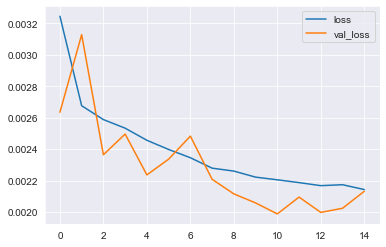

In [27]:
# losses
losses_lstm_less = pd.DataFrame(model_lstm_less.history.history)
losses_lstm_less.to_pickle(os.path.join('comparison','losses_lstm_less.pkl'))
losses_lstm_less[['loss','val_loss']].plot()

In [28]:
# predict values in test set
preds= model_lstm_less.predict(test_generator)
# inverse scale
true_preds = scaler.inverse_transform(preds)
# save
pd.DataFrame(data={'lstm_preds':true_preds.flatten()},
             index=test_df.index).to_pickle(os.path.join('comparison','lstm_preds.pkl'))

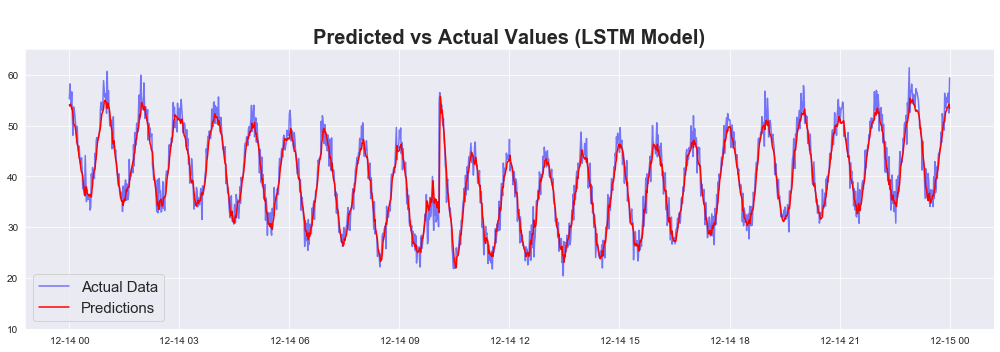

In [29]:
# plot predictions
plt.figure(figsize=(14,5))
plt.title('\nPredicted vs Actual Values (LSTM Model)',fontsize=20, fontweight='bold')
plt.plot(test_df, 'b', label = 'Actual Data', alpha=0.5)
plt.plot(test_df.index, true_preds.flatten(), 'r', label = 'Predictions')
plt.legend(prop={'size': 15})
plt.ylim(10,65)
plt.tight_layout()

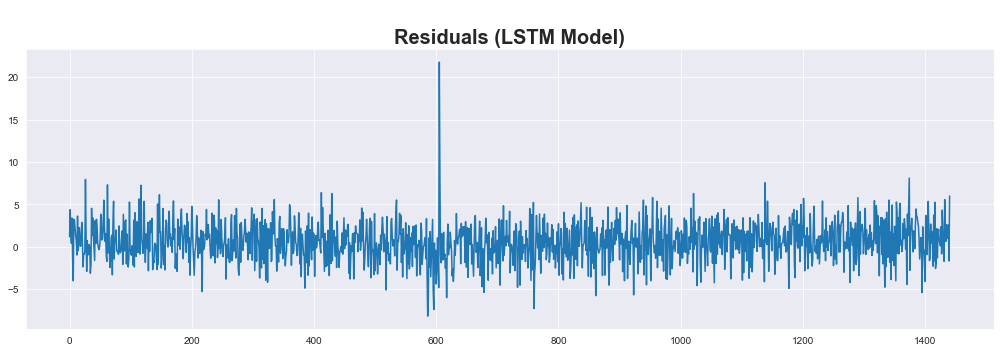

In [30]:
# plot residuals
plt.figure(figsize=(14,5))
plt.title('\nResiduals (LSTM Model)',fontsize=20, fontweight='bold')
plt.plot(test_df.values.flatten()-true_preds.flatten())
plt.tight_layout()

In [31]:
## RMSE
RMSE_LSTM= np.sqrt(mean_squared_error(test_df.values, true_preds.flatten()))
print('RMSE LSTM: ' ,round(RMSE_LSTM,4))

RMSE LSTM:  2.442


In [32]:
# save rmse and run time
comparison= pd.concat([comparison,pd.DataFrame({'model':['LSTM'],
                                                'time':[time_lstm],
                                                'rmse':[RMSE_LSTM]})])

In [33]:
comparison

,model,time,rmse
0,Fourier Transform,0.034534,2.621366
1,SARIMA,149.854580,7.869614
2,TBATS,2420.605045,4.043840
0,LSTM,2502.685699,2.441975


# LSTM (More Neurons)

#### Model

In [34]:
# define model
model_lstm_more = Sequential()

# LSTM layer
model_lstm_more.add(LSTM(100,input_shape=(timesteps, 1), stateful=False))

# Final Prediction
model_lstm_more.add(Dense(1))

model_lstm_more.compile(optimizer='adam', loss='mse')

In [35]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)
start = time()
model_lstm_more.fit(generator,epochs=15,validation_data=val_generator,callbacks=[early_stop])
time_lstm = time()-start

Train for 9960 steps, validate for 1321 steps
Epoch 1/15
9960/9960 [==============================] - 174s 17ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 2/15
9960/9960 [==============================] - 180s 18ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 3/15
9960/9960 [==============================] - 182s 18ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/15
9960/9960 [==============================] - 181s 18ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/15
9960/9960 [==============================] - 182s 18ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/15
9960/9960 [==============================] - 182s 18ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 7/15
9960/9960 [==============================] - 183s 18ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/15
9960/9960 [==============================] - 182s 18ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/15
9960/9960 [==============================] - 182s 18ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/

In [36]:
model_lstm_more.save(os.path.join('comparison','model_lstm_more.h5'))

#### Evaluate

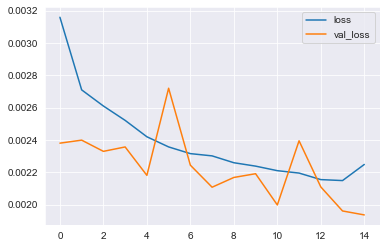

In [37]:
# losses
losses_lstm_more = pd.DataFrame(model_lstm_more.history.history)
losses_lstm_more.to_pickle(os.path.join('comparison','losses_lstm_more.pkl'))
losses_lstm_more[['loss','val_loss']].plot()

In [38]:
# predict values in test set
preds= model_lstm_more.predict(test_generator)
# inverse scale
true_preds = scaler.inverse_transform(preds)
# save
pd.DataFrame(data={'lstm_preds_more':true_preds.flatten()},
             index=test_df.index).to_pickle(os.path.join('comparison','lstm_more_preds.pkl'))

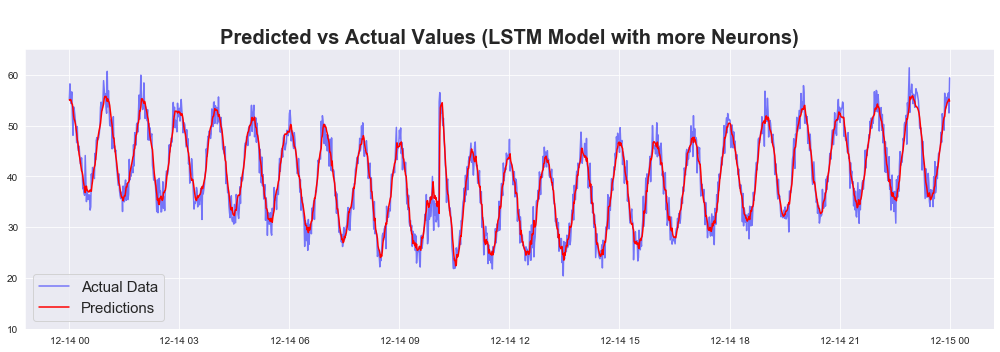

In [39]:
# plot predictions
plt.figure(figsize=(14,5))
plt.title('\nPredicted vs Actual Values (LSTM Model with more Neurons)',fontsize=20, fontweight='bold')
plt.plot(test_df, 'b', label = 'Actual Data', alpha=0.5)
plt.plot(test_df.index, true_preds.flatten(), 'r', label = 'Predictions')
plt.legend(prop={'size': 15})
plt.ylim(10,65)
plt.tight_layout()

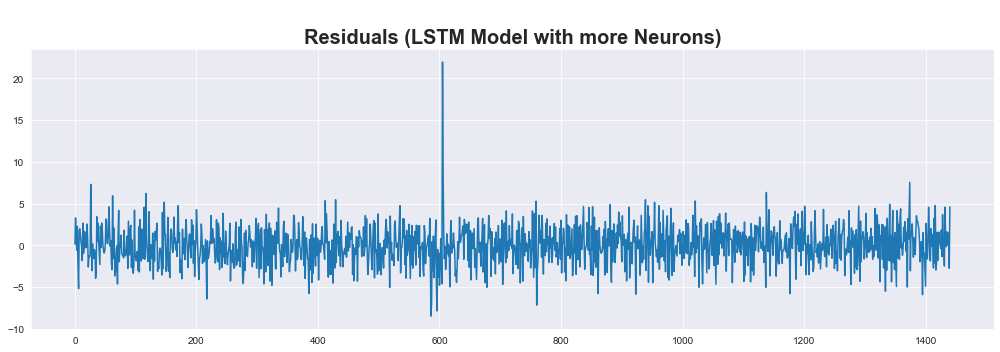

In [40]:
# plot residuals
plt.figure(figsize=(14,5))
plt.title('\nResiduals (LSTM Model with more Neurons)',fontsize=20, fontweight='bold')
plt.plot(test_df.values.flatten()-true_preds.flatten())
plt.tight_layout()

In [41]:
## RMSE
RMSE_LSTM= np.sqrt(mean_squared_error(test_df.values, true_preds.flatten()))
print('RMSE LSTM: ' ,round(RMSE_LSTM,4))

RMSE LSTM:  2.3193


In [42]:
# save rmse and run time
comparison= pd.concat([comparison,pd.DataFrame({'model':['LSTM_More_N'],
                                                'time':[time_lstm],
                                                'rmse':[RMSE_LSTM]})])

In [43]:
comparison

,model,time,rmse
0,Fourier Transform,0.034534,2.621366
1,SARIMA,149.854580,7.869614
2,TBATS,2420.605045,4.043840
0,LSTM,2502.685699,2.441975
0,LSTM_More_N,2722.658126,2.319289


# LSTM (2 Layers)

#### Model

In [44]:
# define model
model_lstm_2 = Sequential()

# LSTM layer
model_lstm_2.add(LSTM(50,input_shape=(timesteps, 1),return_sequences=True, stateful=False))
model_lstm_2.add(LSTM(50, stateful=False))

# Final Prediction
model_lstm_2.add(Dense(1))

model_lstm_2.compile(optimizer='adam', loss='mse')

In [45]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)
start = time()
model_lstm_2.fit(generator,epochs=50,validation_data=val_generator,callbacks=[early_stop])
time_lstm = time()-start

Train for 9960 steps, validate for 1321 steps
Epoch 1/50
9960/9960 [==============================] - 289s 29ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 2/50
9960/9960 [==============================] - 288s 29ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 3/50
9960/9960 [==============================] - 288s 29ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 4/50
9960/9960 [==============================] - 289s 29ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 5/50
9960/9960 [==============================] - 287s 29ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/50
9960/9960 [==============================] - 287s 29ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 7/50
9960/9960 [==============================] - 288s 29ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/50
9960/9960 [==============================] - 288s 29ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/50
9960/9960 [==============================] - 288s 29ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/

In [46]:
model_lstm_2.save(os.path.join('comparison','model_lstm_2.h5'))

#### Evaluate

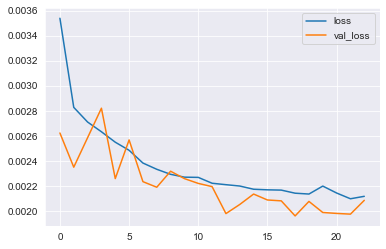

In [48]:
# losses
losses_lstm_2 = pd.DataFrame(model_lstm_2.history.history)
losses_lstm_2.to_pickle(os.path.join('comparison','losses_lstm_2.pkl'))
losses_lstm_2[['loss','val_loss']].plot()

In [49]:
# predict values in test set
preds= model_lstm_2.predict(test_generator)
# inverse scale
true_preds = scaler.inverse_transform(preds)
# save
pd.DataFrame(data={'lstm_2_preds':true_preds.flatten()},
             index=test_df.index).to_pickle(os.path.join('comparison','lstm_2_preds.pkl'))

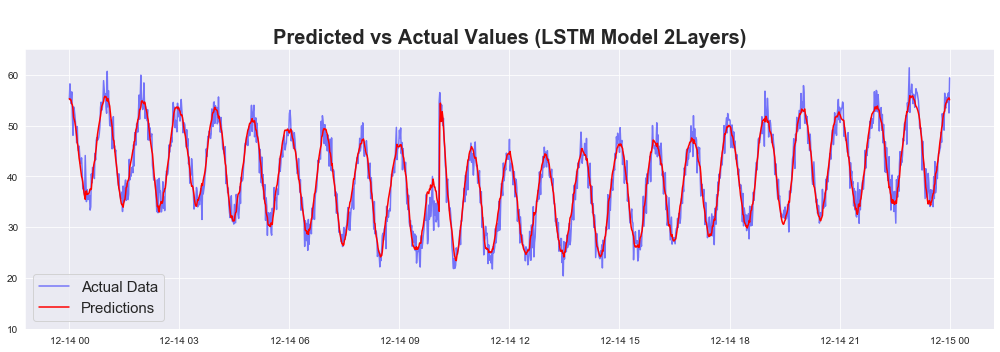

In [50]:
# plot predictions
plt.figure(figsize=(14,5))
plt.title('\nPredicted vs Actual Values (LSTM Model 2Layers)',fontsize=20, fontweight='bold')
plt.plot(test_df, 'b', label = 'Actual Data', alpha=0.5)
plt.plot(test_df.index, true_preds.flatten(), 'r', label = 'Predictions')
plt.legend(prop={'size': 15})
plt.ylim(10,65)
plt.tight_layout()

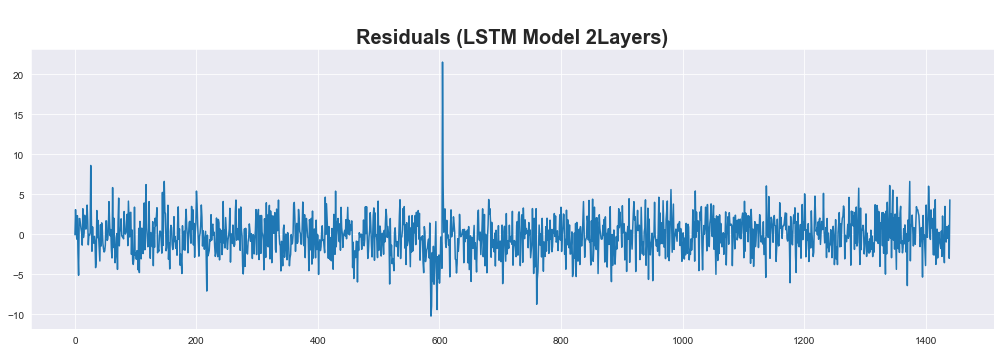

In [51]:
# plot residuals
plt.figure(figsize=(14,5))
plt.title('\nResiduals (LSTM Model 2Layers)',fontsize=20, fontweight='bold')
plt.plot(test_df.values.flatten()-true_preds.flatten())
plt.tight_layout()

In [52]:
## RMSE
RMSE_LSTM= np.sqrt(mean_squared_error(test_df.values, true_preds.flatten()))
print('RMSE LSTM: ' ,round(RMSE_LSTM,4))

RMSE LSTM:  2.409


In [53]:
# save rmse and run time
comparison= pd.concat([comparison,pd.DataFrame({'model':['LSTM_2Layers'],
                                                'time':[time_lstm],
                                                'rmse':[RMSE_LSTM]})])

In [55]:
# comparison path
comp_path= os.path.join('comparison','comparison.pkl')
comp_path_csv= os.path.join('comparison','comparison.csv')
comparison.to_pickle(comp_path)
comparison.to_csv(comp_path_csv, index=False)